# Анализ бизнес-показателей и оценка окупаемости рекламы

## Описание проекта

### Цель исследования

Найти факторы, ведущие к убыточности рекламных компаний и предложить отделу маркетинга рекомендации по исправлению сложившейся ситуации.

### Источник данных

Лог сервера с данными о посещениях пользователей, выгрузка их покупок и сведения о рекламных доходах за период с 1.05.2019 по 27.10.2019 гг; дата проведения анализа 1.11.2019г., в бизнес-плане заложена окупаемость пользователя не позднее 14 дней после привлечения.

**Описание данных:**

Лог сервера с информацией о посещениях сайта *visits_info_short.csv*:

`User Id` — уникальный идентификатор пользователя;

`Region` — страна пользователя;

`Device` — тип устройства пользователя;

`Channel` — идентификатор источника перехода;

`Session Start` — дата и время начала сессии;

`Session End` — дата и время окончания сессии.

Информация о заказах *orders_info_short.csv*:

`User Id` — уникальный идентификатор пользователя;

`Event Dt` — дата и время покупки;

`Revenue` — сумма заказа.

Информация о расходах на рекламу *costs_info_short.csv*:

`dt` — дата проведения рекламной кампании;

`Channel` — идентификатор рекламного источника;

`costs` — расходы на эту кампанию.

### Ход выполнения

1. Загрузка, изучение и подготовка данных.
2. Написание функций для создания профилей пользователей, расчета и визуализации конверсии, удержания, LTV, CAC и ROI.
3. Создание профилей пользователей и проведение исследовательского анализа данных (распределение привлеченных пользователей по странам, устройствам, каналам привлечения, доля платящих).
4. Анализ маркетинговых данных (общая сумма затрат на маркетинг и средняя САС в целом и по отдельным каналам привлечения).
5. Анализ окупаемости рекламы, конверсии и удержания пользователей в целом, а также в разрезе стран, используемых устройств, каналов привлечения.
6. Формулировка выводов о факторах, связанных с неокупаемостью рекламных кампаний, и рекомендаций для отдела маркетинга.

## Загрузка, изучение и подготовка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta 

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Создадим функцию для получения общей информации о датафрейме (формат данных, дубликаты, пропуски и т.д.).

In [3]:
def information(df):
    display(df.dtypes)
    print('\033[1m' + 'Первые 2 строки:' + '\033[0m')
    display(df.head(2))
    print('\033[1m' + 'Количество дубликатов:' + '\033[0m', df.duplicated().sum())
    print('\033[1m' + 'Количество пропусков:' + '\033[0m')  
    print(df.isna().sum())
    print('\033[1m' + 'Доля пропусков:' + '\033[0m')
    print(df.isna().sum() / len(df.index))

Изучим общую информацию о датафрейме хранящем данные о посещениях сайта.

In [4]:
information(visits)

User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

Первые 2 строки:


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35


Количество дубликатов: 0
Количество пропусков:
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
Доля пропусков:
User Id          0.0
Region           0.0
Device           0.0
Channel          0.0
Session Start    0.0
Session End      0.0
dtype: float64


В датафрейме с данными о посещениях сайта нет пропусков и дубликатов. Стоит привести названия столбцов к стилю принятому в Pyton. Для столбцов 'Session Start' и 'Session End' необходимо сменить формат на datetime.

In [5]:
visits.columns = visits.columns.str.lower() #приведение названий стлбцов к общепринятому стилю
visits = visits.rename(columns={'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'})

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start']) #замена формата на datetime
visits['session_end'] = pd.to_datetime(visits['session_end'])

Получим общую информацию о таблице с данными о заказах.

In [7]:
information(orders)

User Id       int64
Event Dt     object
Revenue     float64
dtype: object

Первые 2 строки:


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99


Количество дубликатов: 0
Количество пропусков:
User Id     0
Event Dt    0
Revenue     0
dtype: int64
Доля пропусков:
User Id     0.0
Event Dt    0.0
Revenue     0.0
dtype: float64


Дубликатов и пропусков нет. Нужно привести названия столбцов к общепринятому стилю, и сменить формат в столбце с датой заказа на datetime.

In [8]:
orders.columns = orders.columns.str.lower() #приведение названий стлбцов к общепринятому стилю
orders = orders.rename(columns={'user id' : 'user_id', 'event dt' : 'event_dt'})

In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])#замена формата на datetime

In [10]:
information(costs)

dt          object
Channel     object
costs      float64
dtype: object

Первые 2 строки:


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1


Количество дубликатов: 0
Количество пропусков:
dt         0
Channel    0
costs      0
dtype: int64
Доля пропусков:
dt         0.0
Channel    0.0
costs      0.0
dtype: float64


Пропуски и дубликаты отсутствуют. Нужно заменить название одного из столбцов, и поменять формат данных в столбце dt на datetime.

In [11]:
costs.columns = costs.columns.str.lower() #приведение названий стлбцов к общепринятому стилю

In [12]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date #замена формата на datetime

**Промежуточный вывод**

В ходе проведенной предобработки данных названия столбцов в датафреймах были приведены к общепринятому для Pyton "змеиному" стилю, также формат данных в столбцах, содержащих информацию о дате и времени был изменен на необходимый для анализа datetime.

## Функции для создания профилей пользователей, расчета и визуализации конверсии, удержания, LTV, CAC и ROI

### Функция для создания пользовательских профилей

In [13]:
def get_profiles(sessions, orders, ad_costs):
    profiles = sessions.sort_values(
        by=['user_id', 'session_start']).groupby('user_id').agg(
        {'session_start': 'first', 'channel': 'first', 'device': 'first', 'region': 'first'}).rename(
        columns={'session_start': 'first_ts'}).reset_index()
    
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = profiles.groupby(['dt', 'channel']).agg(
        {'user_id': 'nunique'}).rename(columns={'user_id': 'unique_users'}).reset_index()
    
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on=['dt', 'channel'], how='left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция для расчета удержания

In [14]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time 

### Фукция для расчета конверсии

In [15]:
def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_purchases = purchases.sort_values(
        by=['user_id', 'event_dt']).groupby('user_id').agg({'event_dt': 'first'}).reset_index()

    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time 

### Функция для расчета LTV и ROI

In [16]:
def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'cac'})
        
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time

### Функция для сглаживания

In [17]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])

    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
   
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [19]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визкализации LTV и ROI

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Создание профилей пользователей и проведение исследовательского анализа данных

### Создание пользовательских профилей и определение минимальной и максимальной даты привлечения пользователей

Для создания пользовательских профилей используем функцию get_profiles.

In [21]:
profiles = get_profiles(visits, orders, costs)

In [22]:
profiles.head() #профили пользователей

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [23]:
profiles['dt'].min() #минимальная дата привлечения пользователя

datetime.date(2019, 5, 1)

In [24]:
profiles['dt'].max() #максимальная дата привлечения пользователя

datetime.date(2019, 10, 27)

### Анализ пользователей по странам

In [25]:
profiles_countries = profiles.groupby('region')[['user_id', 'payer']].agg({'user_id' : 'nunique', 'payer' : 'mean'})
profiles_countries['payer'] = (profiles_countries['payer'] * 100).round(1)
profiles_countries.sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,6.9
Germany,14981,4.1
UK,17575,4.0
France,17450,3.8


Пользователи приходят из четырёх стран: США, Германии, Великобритании и Франции. Подавляющее большинство пользователей приходят из США (примерно в 6-7 раз выше, чем из остальных стран), при этом доля платящих пользователей наибольшая - 6,9%. Пользователей из Великобритании и Франции примерно равное количество, меньше всего пользователей приходит из Германии. Доля платящих пользователей в Германия и Великобритания практически одинакова (4,1% и 4% соответственно), самый низкий показатель наблюдается во Франции - 3,8%.

### Анализ пользователей по устройствам

In [26]:
profiles_devices = profiles.groupby('device')[['user_id', 'payer']].agg({'user_id' : 'nunique', 'payer' : 'mean'})
profiles_devices['payer'] = (profiles_devices['payer'] * 100).round(1)
profiles_devices.sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,6.4
iPhone,54479,6.2
Android,35032,5.9
PC,30455,5.0


Наибольшее количесвтво пользователей предпочитает iPhone, существенно меньшее количество пользователей используют устройства на базе Android. Наименьшее и почти одинаковое количество пользователей предпочитают Mac и PC. Самая высокоя доля платящих наблюдается среди пользователей Mac (6,4%), далее с небольшим отрывом следуют пользователи предпочитающие iPhone(6,2%). Среди использующих устройства на платформе Android, платят 5,9% пользователей, и наименьшая доля платящих среди пользователей использующих PC (5,0%). Учитывая общее количество пользователей, больше всего платящих используют iPhone. 

### Анализ пользователей по рекламным источникам

In [27]:
profiles_channels = profiles.groupby('channel')[['user_id', 'payer']].agg({'user_id' : 'nunique', 'payer' : 'mean'})
profiles_channels['payer'] = (profiles_channels['payer'] * 100).round(1)
profiles_channels.sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,12.2
AdNonSense,3880,11.3
lambdaMediaAds,2149,10.5
TipTop,19561,9.6
RocketSuperAds,4448,7.9
WahooNetBanner,8553,5.3
YRabbit,4312,3.8
MediaTornado,4364,3.6
LeapBob,8553,3.1


Среди пользователей пришедших через рекламные источники, наибольшее количество пришло через FaceBoom, второе место по количеству привлеченных пользователей занимает TipTop. Далее следуют каналы каждый из которых привлек около 8500 пользователей - OppleCreativeMedia, LeapBob и WahooNetBanner. Ещё три канала привлекли каждый около 4500 пользователей - RocketSuperAds. Наименьшее количество пользователей привлекли AdNonSense и lambdaMediaAds. Если учитывать всех пользователей, то подавляющее большинство из них пришли самостоятельно, а не через один из рекламных каналов.

Наиболее высокая доля платящих пользователей наблдается среди привлеченных через FaceBoom, этот же канал и в целом дал наибольшее количество платящих пользователей. Также долей платящих пользователей выше 10% могут похвастаться AdNonSense и lambdaMediaAds, но учитывая небольшее общее количество привлеченных пользователей, количество платящих получилось весьма скромным. Вторым по количеству и четвертым по доле привлеченных платящих пользователей является TipTop. Доля платящих  среди пользователей пришедших самостоятельно оказалась наименьшей, но учитывая их большое количество в абсолютных цифрах их количество уступает только двум рекламным источникам - FaceBoom и TipTop (а ещё для их привлечения не тратяться деньги на рекламу, что тоже приятно).

### Промежуточный вывод

- Подавляющее большинство пользователей приходит из США, среди них же наблюдается наибольшая доля платящих.
- Большая часть платящих пользователей предпочитают устройства от компании Apple (Mac и iPhone).
- Рекламные каналы FaceBoom и TipTop, привлекли больше всего платящих пользователей и отличаются высокой долей платящих среди привлеченных.
- Рекламные каналы AdNonSense и lambdaMediaAds также характеризуются высокой долей платящих пользователей среди привлеченных, но т.к. общее количество привлеченных ими пользователей невелико, то и платящих пользователей они привлекли мало.
- Можно сказать, что наиболее высокая вероятность перейти в категорию платящих у пользователей из США, использующих Mac или iPhone и привлеченных через один из четырёх указанных выше рекламных каналов; а вот вероятность получить плату от пользователя из Франции, использующего PC и пришедшего самостоятельно, не так высока. 

## Анализ маркетинговых данных

### Общие расходы на маркетинг

In [28]:
profiles['acquisition_cost'].sum().round(2) #расчет общей суммы затраченной на маркетинг

105497.3

Общая сумма расходов на маркетинг составила почти 105,5 тыс денег (наверное $).

Выясним как общие траты на маркетинг распределены по рекламным источникам.

In [29]:
profiles.groupby('channel')['acquisition_cost'].sum().sort_values(ascending=False)

channel
TipTop                54751.30
FaceBoom              32445.60
WahooNetBanner         5151.00
AdNonSense             3911.25
OppleCreativeMedia     2151.25
RocketSuperAds         1833.00
LeapBob                1797.60
lambdaMediaAds         1557.60
MediaTornado            954.48
YRabbit                 944.22
organic                   0.00
Name: acquisition_cost, dtype: float64

Больше всего денег было потрачено на рекламу через TipTop и FaceBoom, т.е. те рекламные каналы, которые принесли больше всего пользователей, в т.ч. и платящих. Однако на TipTop было потрачено в 1,7 раза большая сумма, чем на FaceBoom, но при этом последний привлек больше клиентов, доля платящих среди которых также выше. 

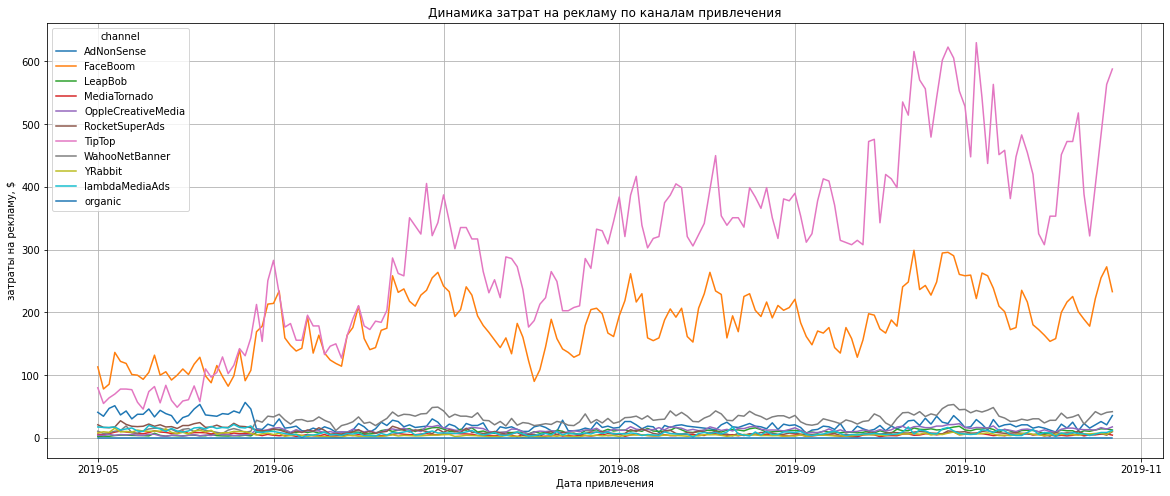

In [30]:
profiles.pivot_table(index='dt', columns='channel', 
                     values='acquisition_cost', aggfunc='sum').plot(grid=True, figsize=(20, 8))
plt.ylabel('затраты на рекламу, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика затрат на рекламу по каналам привлечения')
plt.show()

На графике выделяются самые дорогие рекламные каналы TipTop и FaceBoom. В обоих случаях для этих двух каналов наблюдается рост затрат на рекламу в течение периода наблюдения, в большей степени на канале TipTop.

Для визуализации стоимости привлечения во времени построим сводную таблицу, где в качестве названий строк выступят даты привлечения пользователей, а в качестве названий столбцов - рекламный источник. Полученную таблицу визуализируем линейной диаграммой. 

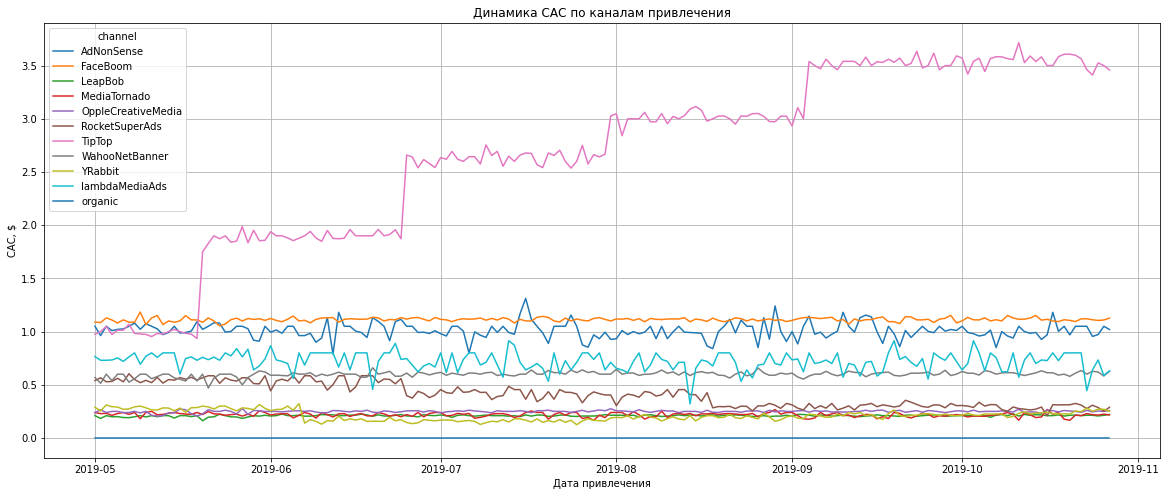

In [31]:
profiles.pivot_table(index='dt', columns='channel', 
                     values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(20, 8))
plt.ylabel('САС, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

В динамике стоимости привлечения пользователей по различным каналам, резко выделяется линия, отражающая компанию TipTop. Во-первых, как уже было сказано ранее, стоимость рекламы в этом канале самая высокая. Во-вторых, САС по всем рекламным каналам, за исключением TipTop, относительно стабилен на всем протяжении наблюдения, в то время как стоимость привлечения через TipTop периодически (примерно раз в месяц) довольно резко возрастала и с сентября 2019 года вышла на, так сказать, пиковые значения.

### Средняя цена привлечения одного пользователя

Рассчитаем средний САС по всему проекту. Не будем учитывать при расчёте органических пользователей, так как на их привлечение не затрачиваются рекламные деньги.

In [32]:
profiles_not_organic = profiles.query('channel != "organic"') #исключение органических пользователей

In [33]:
profiles_not_organic['acquisition_cost'].mean().round(2)

1.13

Средний САС по проекту составил 1,13$. Теперь рассчитаем средний САС по различным каналам привлечения.

In [34]:
profiles_not_organic.groupby('channel')['acquisition_cost'].mean().round(2).sort_values(ascending=False)

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
Name: acquisition_cost, dtype: float64

Средний САС превышающий среднее значение по проекту имеют четыре рекламных канала, которые уже назывались ранее, как каналы с наибольшей долей платящих пользователей от всех привлеченных. Самый высокий средний САС у пользователей, привлеченных рекламой TipTop - 2,80. Средний САС второй по этому показателю рекламной кампании от FaceBoom, составляет 1,11. Третью и четвертую позицию занимают AdNonSense и lambdaMediaAds со средним САС - 1,01 и 0,72 соответственно. Средний САС по остальным рекламным каналам ниже среднего САС по проекту.

### Промежуточный вывод

- Общая сумма расходов на маркетинг составила 105 497,30.
- Средний САС по проекту - 1,13.
- Самый дорогой источник привлечения - TipTop, характеризуется самой высокой стоимостью рекламной кампании (54 751,30), и самым высоким средним САС (2,80).
- Динамика САС по всем каналам, за исключением TipTop относительно стабильна.
- Динамика САС по рекламному каналу TipTop характеризуется наличием периодических (примерно раз в месяц) скачков, приводивших к увеличению САС.  

## Анализ окупаемости рекламы, конверсии и удержания пользователей в целом, а также в разрезе стран, используемых устройств, каналов привлечения

Исходя из поставленных задач и описания проекта горизонт анализа составляет 14 дней, а момент анализа 1.11.2019г. Так как нам нужно проанализировать окупаемость рекламы, считаю нецелесообразным включение в анализ органических пользователей, т.к. они приходят в приложение самостоятельно, а не в результате рекламных компаний.

In [35]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [36]:
profiles_not_organic = profiles.query('channel != "organic"') #исключение органических пользователей

### Анализ общей окупаемости рекламы

In [37]:
ltv_raw_general, ltv_general, ltv_history_general, roi_general, roi_history_general = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days)

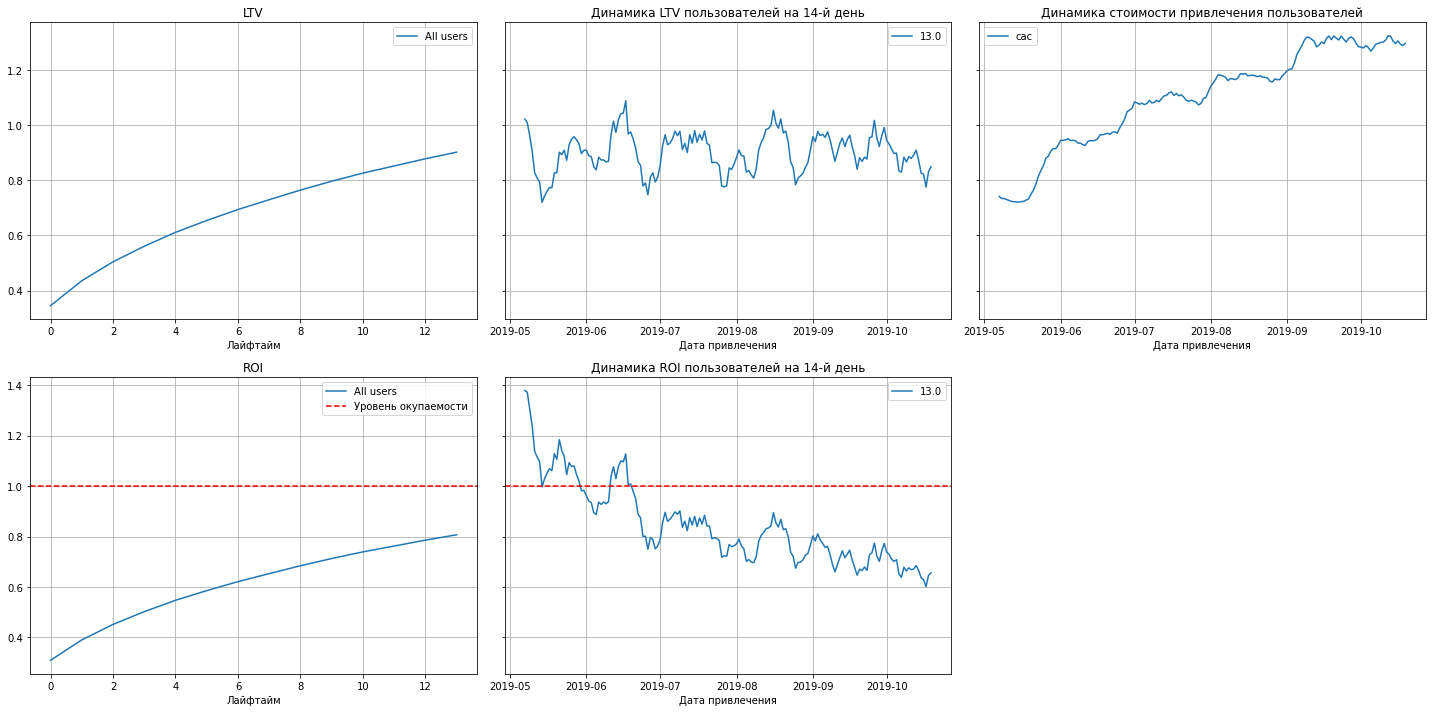

In [38]:
plot_ltv_roi(ltv_general, ltv_history_general, roi_general, roi_history_general, horizon_days, window=7)

- LTV постоянно плавно растет, как и должно быть в норме.
- В динамике LTV на 14-й день есть некоторые колебания, но они не столь значительны.
- С показателем САС явно что-то не в порядке, он скачкообразно растёт, и кривая этого роста очень напоминает кривую роста рекламного бюджета TipTop. Совпадение??? Не думаю!
- Реклама не окупается ROI достигает показателя чуть больше 0,8. Видимо, это связано с ростом расходов на рекламу описанным выше, тем более в динамике ROI видно, что когда (в мае-июне) затраты на рекламу были наименьшими она ещё окупалась.

### Анализ окупаемости рекламы с разбивкой по устройствам

In [39]:
ltv_raw_devices, ltv_devices, ltv_history_devices, roi_devices, roi_history_devices = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['device'])

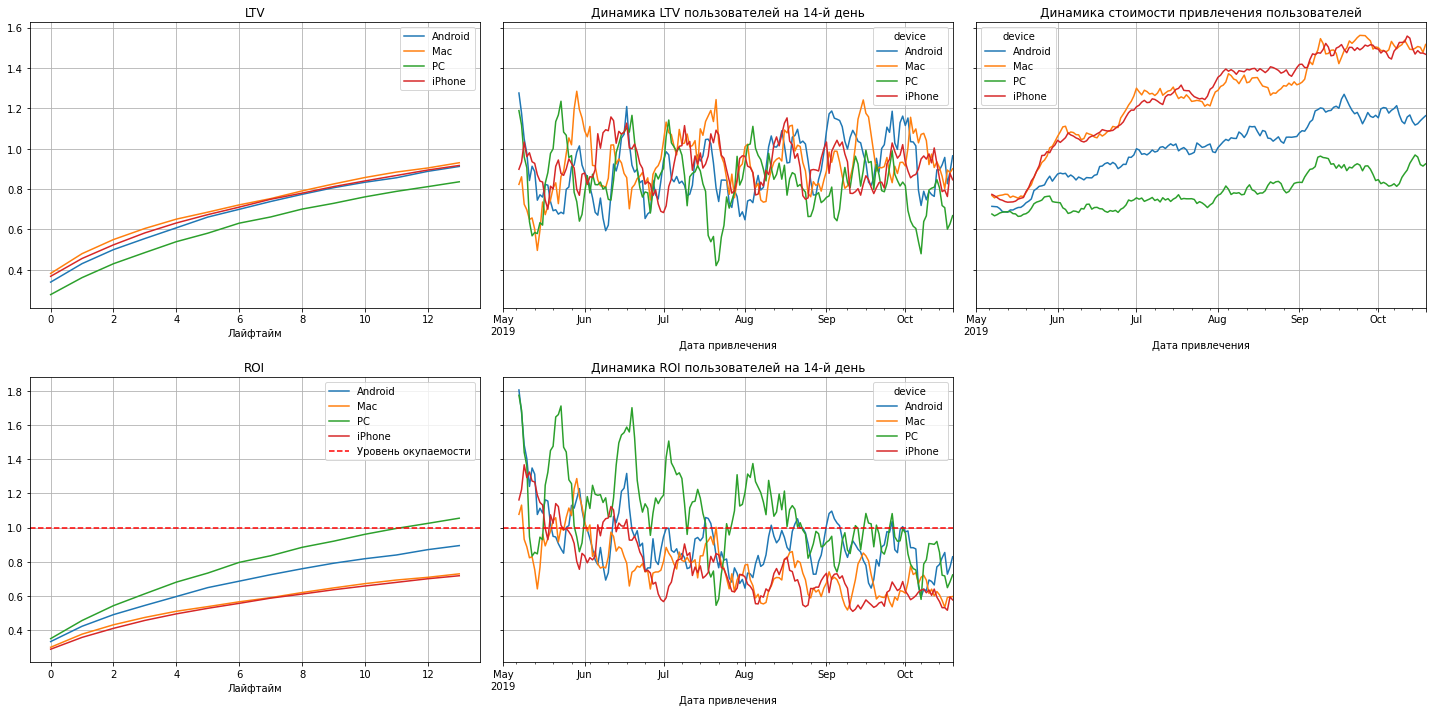

In [40]:
plot_ltv_roi(ltv_devices, ltv_history_devices, roi_devices, roi_history_devices, horizon_days, window=7)

Самые высокие LTV у пользователей Maс и iPhone, чуть ниже у юзеров на Android, и самый низкий LTV у пользователей PC. Однако при этом стоимость привлечения пользователей на Mac и iPhone самая высокая и интенсивней всего растет, ниже но также характеризуется ростом стоимость привлечения пользователей Android, и наименьшие затраты уходят на привлечение пользователей на PC, хотя нужно отметить, что стоимость их привлечения также показывает ни такой резкий, но достаточно стабильный рост. Высокие затраты на привлечение выливаются в неокупаемость рекламы по устройствам Mac, iPhone и Android, при этом Mac и iPhone показывают самый низкий ROI (около 70%). В тоже время реклама для пользователей на PC окупается к 12 "дню жизни".

### Анализ окупаемости рекламы с разбивкой по странам

In [41]:
ltv_raw_regions, ltv_regions, ltv_history_regions, roi_regions, roi_history_regions = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['region'])

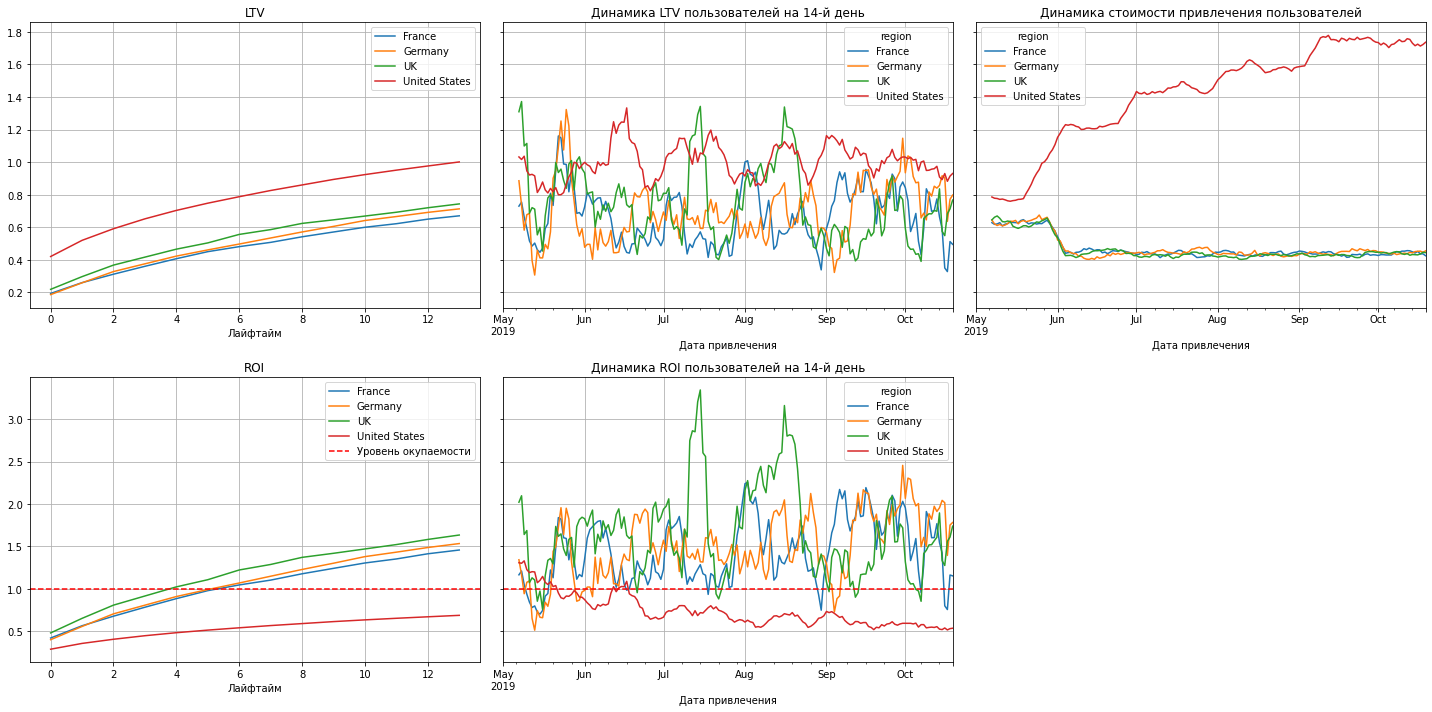

In [42]:
plot_ltv_roi(ltv_regions, ltv_history_regions, roi_regions, roi_history_regions, horizon_days, window=7)

Самый высокий показатель LTV имеют пользователи из США, далее с довольно приличным отставанием следует пользователи из Великобритании и чуть более низкий LTV харакетризует пользователей из Германии и Франции. Одновременно с этим привлечение пользователей из США обходиться компании значительно дороже привлечения пользователей из других стран, при этом первый показатель неумолимо растет, в то время как стоимость привлечения клиентов из других стран снижается в июне и на протяжении всего периода наблюдения остается стабильной. Как итог реклама в США не окупается, что приводить к неокупаемости рекламы в целом, так как по остальным странам наблюдается достаточно быстрая окупаемость рекламы (Великобритания на 5 день, Франция и Германия на 6 день после привлечения).

Изучим рекламу в США и Европейских странах по каналам привлечения и устройствам.

In [43]:
ltv_raw_USA, ltv_USA, ltv_history_USA, roi_USA, roi_history_USA = get_ltv(
    profiles_not_organic.query('region == "United States"'), 
    orders, observation_date, horizon_days, dimensions=['channel']) #США по каналам привлечения

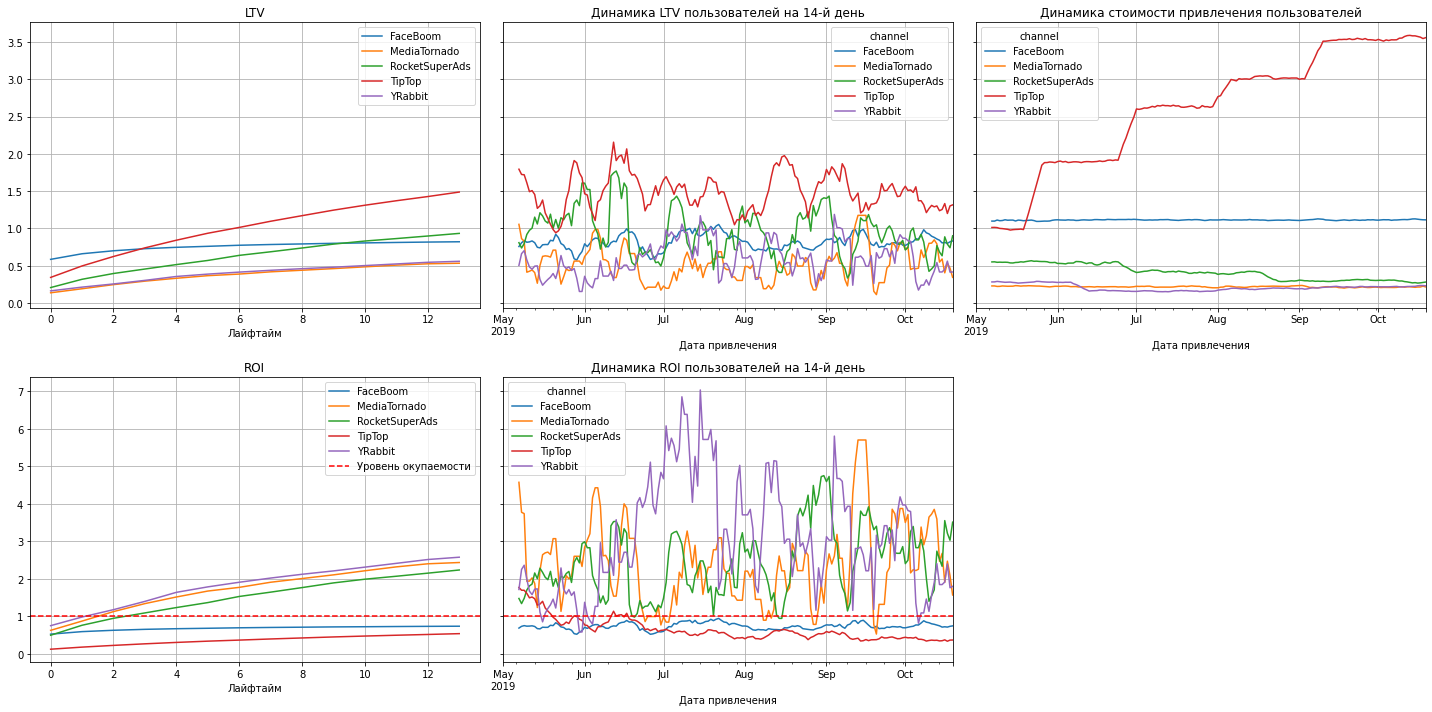

In [44]:
plot_ltv_roi(ltv_USA, ltv_history_USA, roi_USA, roi_history_USA, horizon_days, window=7)

Среди пользователей США не окупается реклама по двум каналам привлечения TipTop и FaceBoom. По каналам MediaTornado, RocketSuperAds и YRabbit реклама окупается уже на второй третий день от мосента привлечения пользователя.

In [45]:
ltv_raw_USA_d, ltv_USA_d, ltv_history_USA_d, roi_USA_d, roi_history_USA_d = get_ltv(
    profiles_not_organic.query('region == "United States"'), 
    orders, observation_date, horizon_days, dimensions=['device']) #США по устройствам

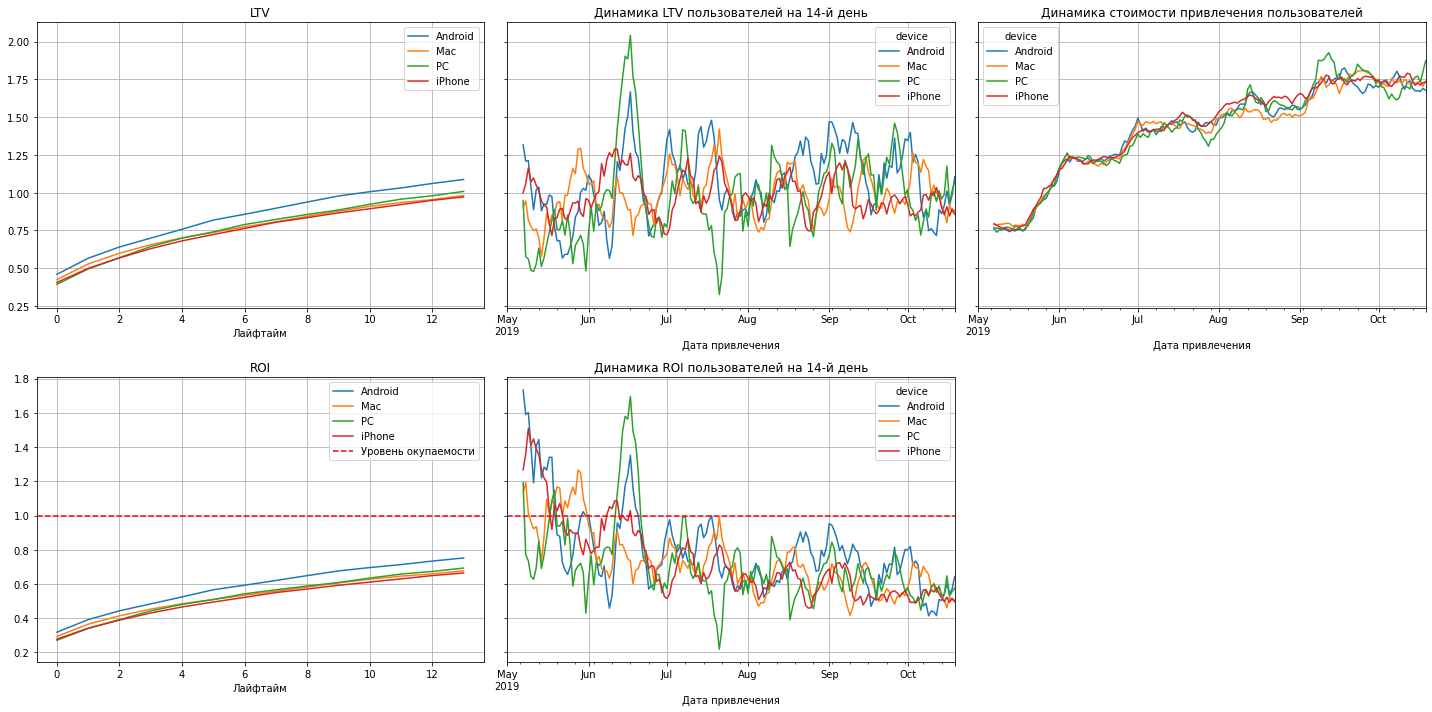

In [46]:
plot_ltv_roi(ltv_USA_d, ltv_history_USA_d, roi_USA_d, roi_history_USA_d, horizon_days, window=7)

Реклама стабильно не окупается на всех устройствах, значит особого влияния используемых устройств на окупаемость рекламы в США нет.

In [47]:
ltv_raw_Europe, ltv_Europe, ltv_history_Europe, roi_Europe, roi_history_Europe = get_ltv(
    profiles_not_organic.query('region != "United States"'), 
    orders, observation_date, horizon_days, dimensions=['channel'])

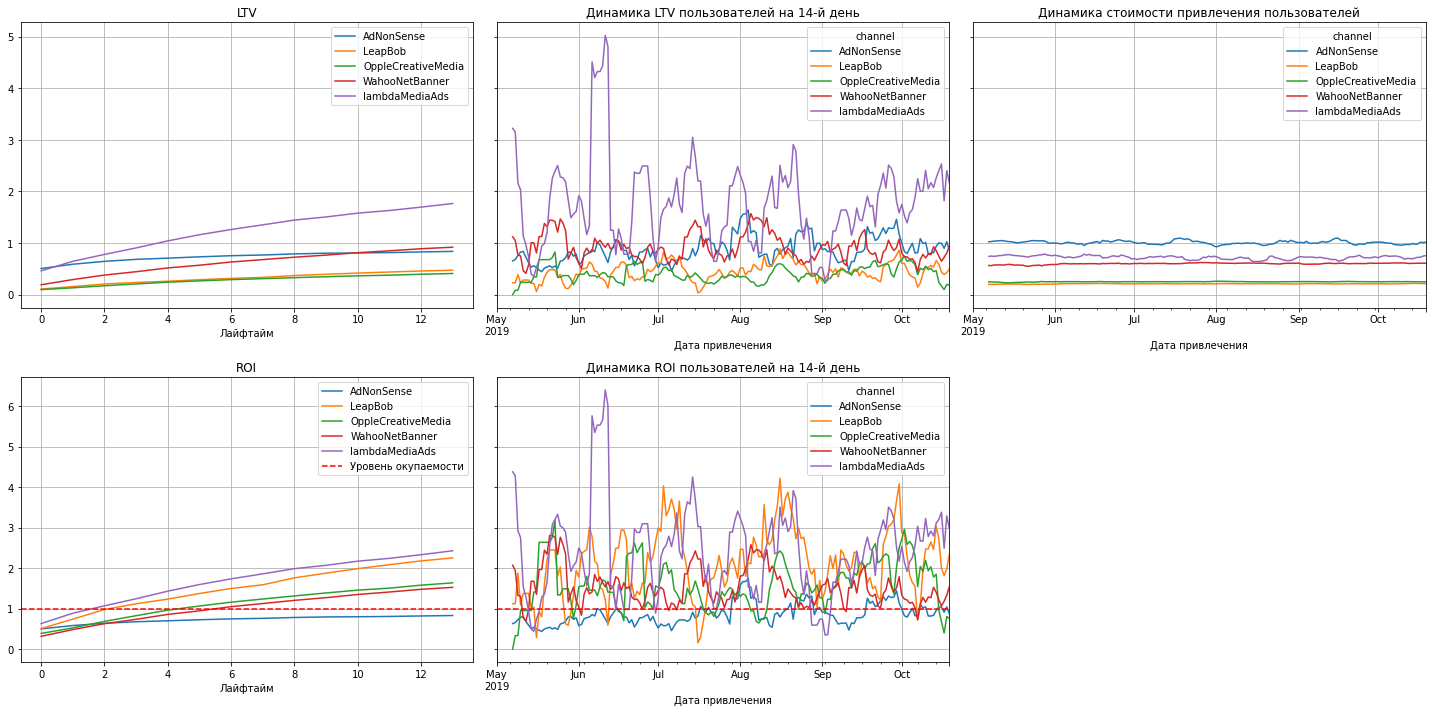

In [48]:
plot_ltv_roi(ltv_Europe, ltv_history_Europe, roi_Europe, roi_history_Europe, horizon_days, window=7)

In [49]:
ltv_raw_Europe_d, ltv_Europe_d, ltv_history_Europe_d, roi_Europe_d, roi_history_Europe_d = get_ltv(
    profiles_not_organic.query('region != "United States"'), 
    orders, observation_date, horizon_days, dimensions=['device'])

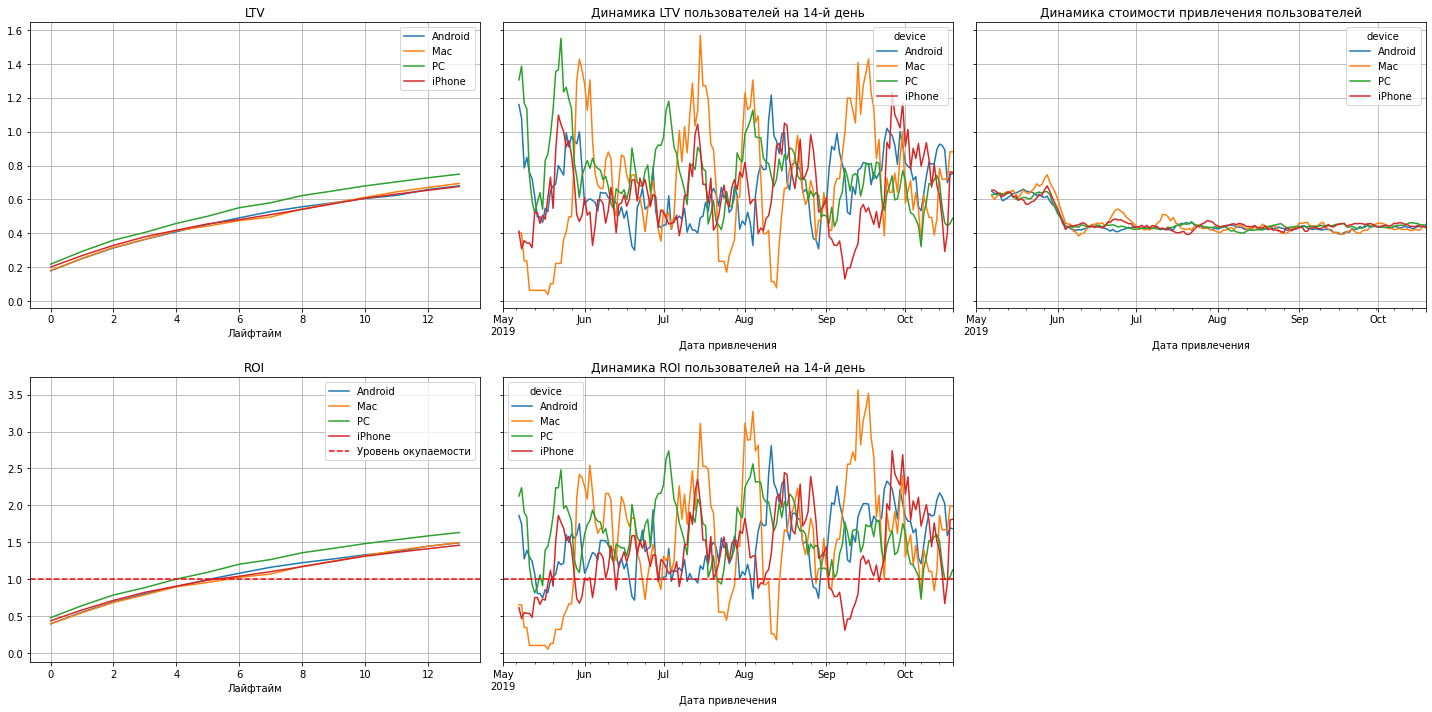

In [50]:
plot_ltv_roi(ltv_Europe_d, ltv_history_Europe_d, roi_Europe_d, roi_history_Europe_d, horizon_days, window=7)

В Европейских странах не окупилась только одна рекламная кампания - AdNonSense. Быстрее всего (2-3 день после привлечения) окупилась реклама через каналы lambdaMediaAds и LeapBob. Реклама на всех устройствах стабильно окупается, на день быстрее это происходит на PC.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

In [51]:
ltv_raw_channels, ltv_channels, ltv_history_channels, roi_channels, roi_history_channels = get_ltv(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['channel'])

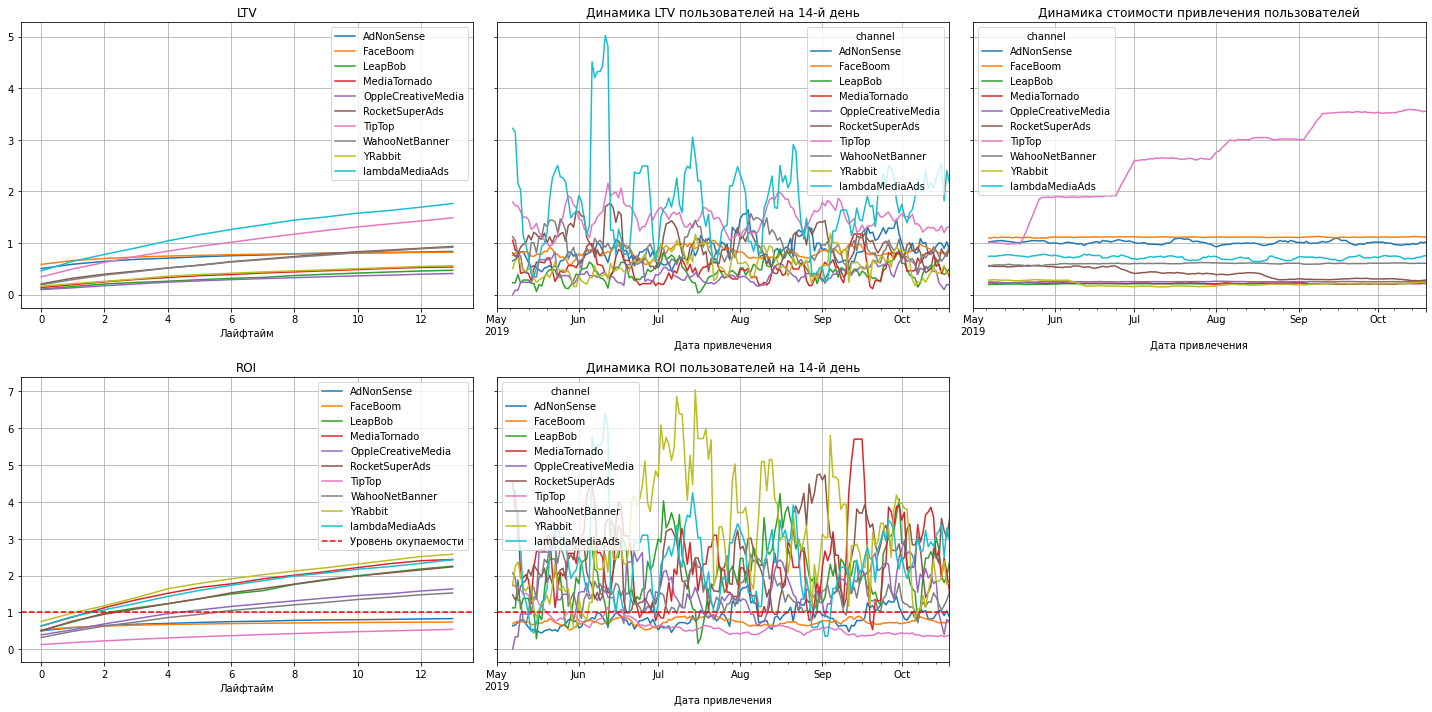

In [52]:
plot_ltv_roi(ltv_channels, ltv_history_channels, roi_channels, roi_history_channels, horizon_days, window=7)

Наиболее высоким LTV характеризуются пользователи, привлеченные через каналы lambdaMediaAds и TipTop. В динамике стоимости привлечения пользователей выделяется канал TipTop, стоимость привлечения в нем постоянно растёт в течение всего периода наблюдения, по остальным канал стоимость привлечения была стабильной. Большинство рекламных компаний окупилось, исключение составляют TipTop, FaceBoom (привлекающие большинство пользователей) и AdNonSense, на которые было потрачено больше всего средств.

### Изучение конверсии и удержания

#### Изучение конверсии и удержания с разбивкой по устройствам

In [53]:
retention_raw_devices, retention_devices, retention_history_devices = get_retention(
    profiles_not_organic, visits, observation_date, horizon_days, dimensions=['device'])

In [54]:
conversion_raw_devices, conversion_devices, conversion_history_devices = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['device'])

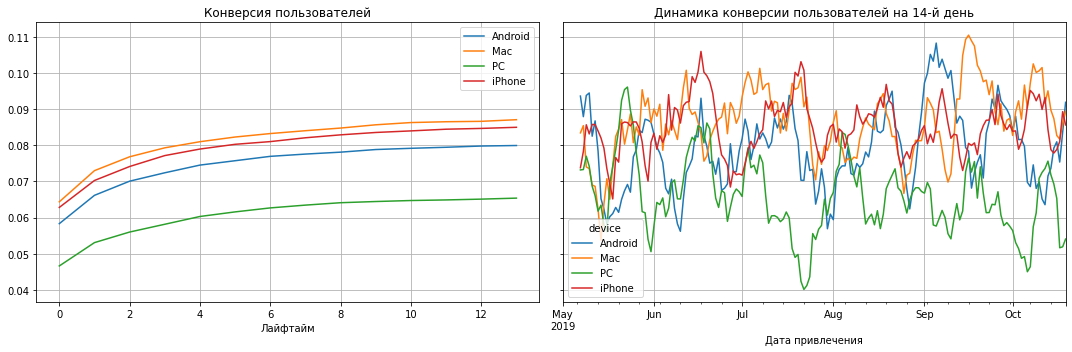

In [55]:
plot_conversion(conversion_devices, conversion_history_devices, horizon_days, window=7)

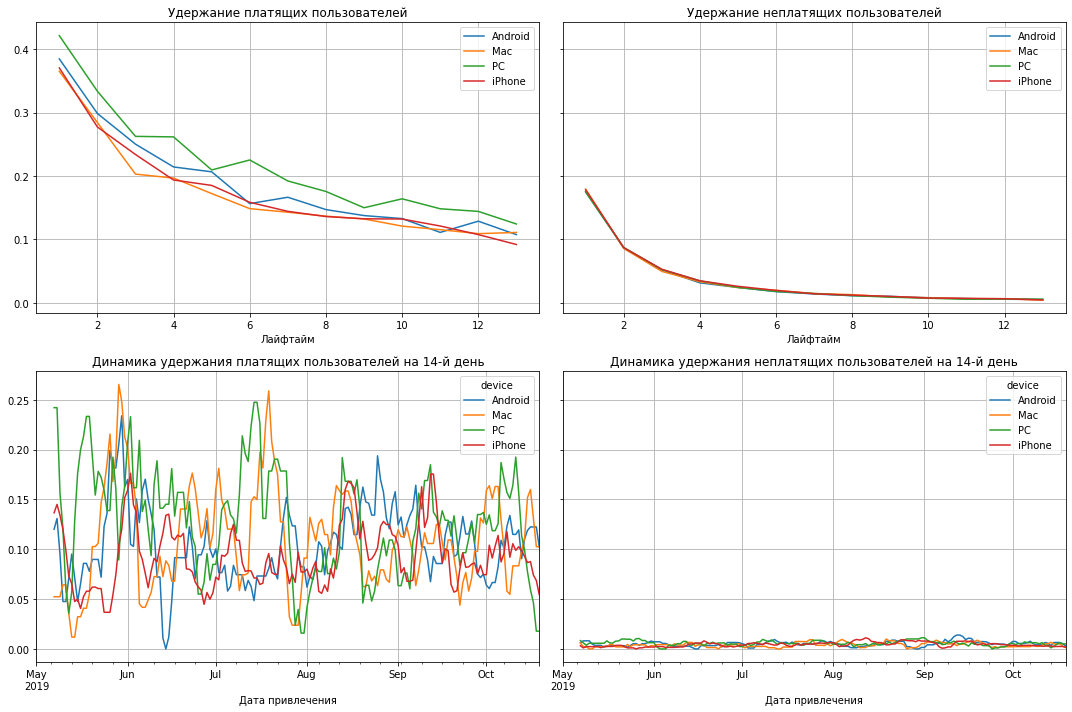

In [56]:
plot_retention(retention_devices, retention_history_devices, horizon_days, window=7)

Наиболее высокой конверсией отмечаются пользователи Mac и iPhone, у пользователей PC конверсия существенно ниже. Удержание платящих пользователей, наоборот наибольшое, однако удержание пользователей на других платформах ниже, но отличается не столь разительно.

#### Изучение конверсии и удержания с разбивкой по странам

In [57]:
retention_raw_regions, retention_regions, retention_history_regions = get_retention(
    profiles_not_organic, visits, observation_date, horizon_days, dimensions=['region'])

In [58]:
conversion_raw_regions, conversion_regions, conversion_history_regions = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['region'])

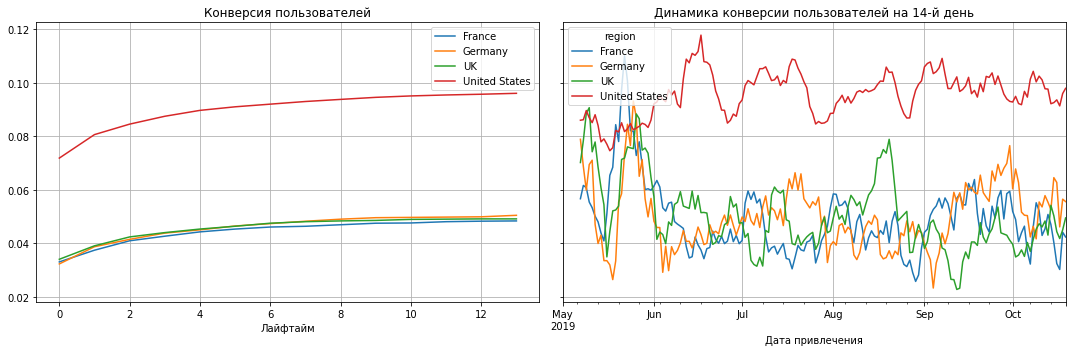

In [59]:
plot_conversion(conversion_regions, conversion_history_regions, horizon_days, window=7)

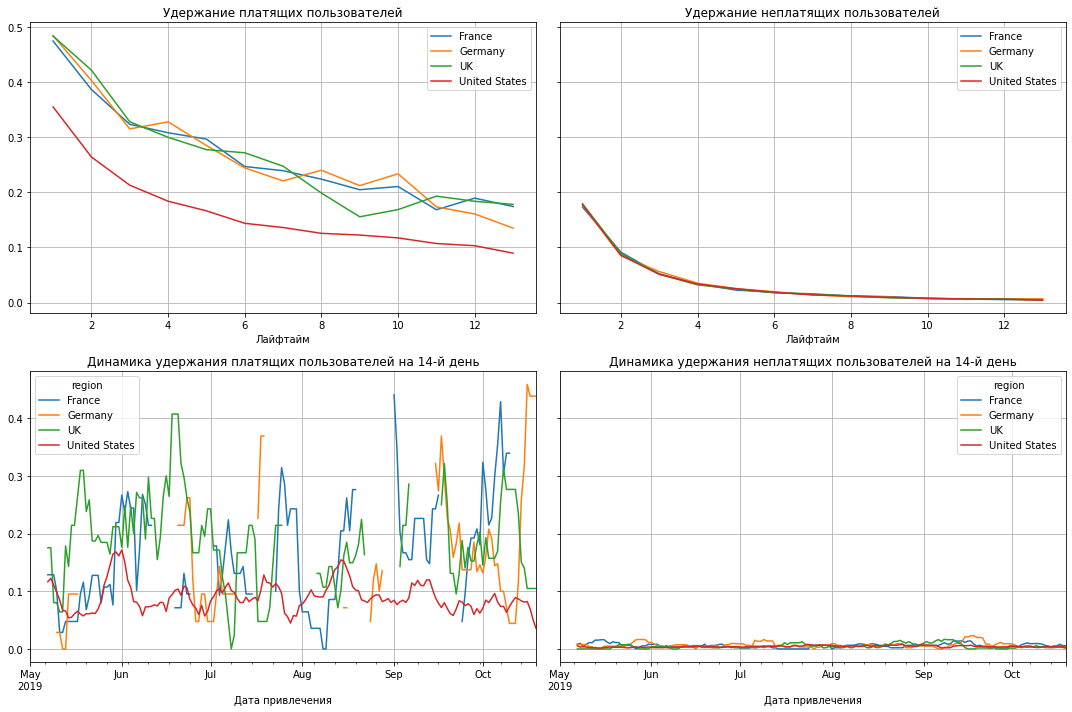

In [60]:
plot_retention(retention_regions, retention_history_regions, horizon_days, window=7)

Конверсия пользователей из США значительно превышает конверсию пользователей из других стран, при этом удержание платящих пользователей из США наиболее низкое.

#### Изучение конверсии и удержания с разбивкой по рекламным каналам

In [61]:
retention_raw_channels, retention_channels, retention_history_channels = get_retention(
    profiles_not_organic, visits, observation_date, horizon_days, dimensions=['channel'])

In [62]:
conversion_raw_channels, conversion_channels, conversion_history_channels = get_conversion(
    profiles_not_organic, orders, observation_date, horizon_days, dimensions=['channel'])

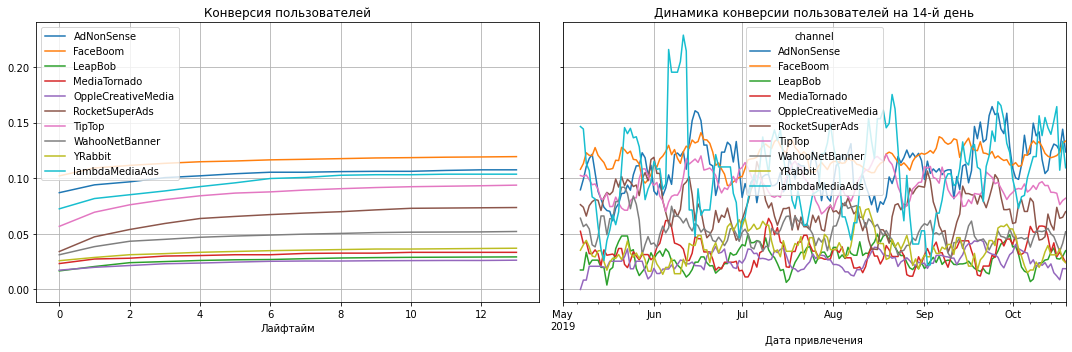

In [63]:
plot_conversion(conversion_channels, conversion_history_channels, horizon_days, window=7)

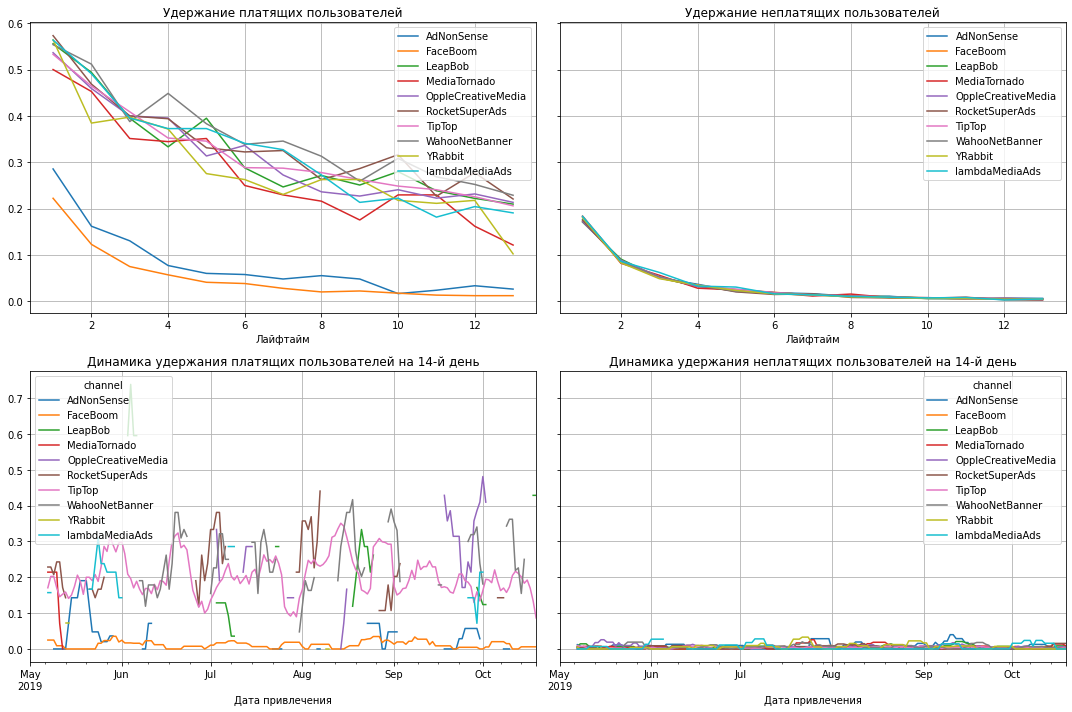

In [64]:
plot_retention(retention_channels, retention_history_channels, horizon_days, window=7)

Самыми высокими показателями конверсии отличаются такие рекламные каналы, как FaceBoom, AdNonSense, lambdaMediaAds и TipTop. При анализе удержания выявлено два проблемных канала - FaceBoom и AdNonSense. Удержание пользователей пришедших через эти каналы существенно ниже, по сравнению с остальными каналами.

### Помежуточные выводы

- В целом реклама не окупается и это, вероятно, связано с постоянным увеличением стоимости привлечения пользователей.
- В разрезе по устройствам: на 12-й день окупилась реклама для пользователей на PC, на остальных устройствах реклама не окупилась.
- В разрезе по странам: стоимость привлечения пользователей из США постоянно увеличивается, стоимость привлечения пользователей из других стран снижается в начале периода наблюдения и затем остаётся стабильной; для пользователей из США реклама не окупается, реклама в других странах окупилась.
- В разрезе по рекламным каналам: выделяется рекламный канал TipTop, стоимость привлечения пользователей через который растёт на протяжении всего периода наблюдения; окупились все рекламные кампании за исключением 3-х: TipTop, FaceBoom и AdNonSense.
- В разрезе усторойств самая высокая конверсия наблюдается у пользователей Mac и iPhone, самая низкая у пользователей PC, при этом удержание по устройствам сильно пе различается.
- В разрезе стран самая высокая конверсия регистрируется у пользователей США (существенно выше остальных стран), при этом удержание платящих пользователей существенно ниже остальных стран.
- В разрезе рекламных каналов два выделяются очень низкими показателями удержания пользователей - FaceBoom и AdNonSense.

Исходя из представленных данных можно сделать вывод о том, что к неокупаемости рекламы приводит провал рекламных кампаний среди пользователей из США и рекламы через каналы TipTop, FaceBoom и AdNonSense.

## Общие выводы и рекомендации для маркетингового отдела

По результатам исследования мы видим, что среди стран, из которых приходят пользователи, единственной в которой реклама не окупается является США. Из рекламных каналов убыточными являются каналы TipTop, FaceBoom и AdNonSense. Также нужно отметить что рекламу в США и рекламу через канал TipTop, объединяет тот факт, что показатель стоимости привлечения пользователя в обоих случаях растет сходным образом на протяжении всего периода наблюдения, что в конечном счёте, несмотря на большую долю платящих пользователей, приводит к неокупаемости рекламы. Также высокие расходы на рекламу в перчисленных случаях сочетаются с высокой конверсией (а в случае с США ещё и с низким удержанием пользователей), что в сочетании с перечисленными выше фактами, наводит нас на мысль о том, что неокупаемость рекламы может быть связана с неудачным выбором системы её оплаты. Например мы оплачиваем рекламу способом СРС, в этом случае, чем больше кликов по рекламному объявлению тем больше денег нам придется заплатить. На фоне высокой конверсии количество переходов будет большим и мы заплатим за рекламу внушительную сумму, но сколько таких переходов по рекламному объявлению конвертируется в покупку мы не знаем. Как итог денег на рекламу мы можем потратить много, но она не окупиться.

В случае с рекламными каналами FaceBoom и AdNonSense траты на рекламу не растут, значит неокупаемость не связана с этой причиной. При анализе удержания платящих пользователей пришедших через данные каналы, мы получили наиболее низкие значения этого показателя (т.е. платящие клиенты пришедшие через эти каналы возвращаются значительно реже пришедших через иные), что и может являться причиной неокупаемости.

Исходя из вышесказанного можно сформулировать следующие рекомендации для отдела маркетинга:
1. Пересмотр и изменение модели оплаты рекламы (замена способа оплаты CPC на CPL или CPA), для привлечения пользователей из США и через канал TipTop.
2. Для каналов с низким удержанием провести более детальный анализ информации о пользователях приходящих через данные каналы (относятся ли приходящие пользователи к целевым группам нашего продукта?, не сталкиваются ли они с техническими проблемами чаще остальных пользователей?, не является ли избыточным то количество переходов которое пользователь должен совершить от клика по рекламе до установки приложения? и т.д.), с целью выяснения и воздействия на причины такого низкого удержания.
3. Перераспределения рекламного бюджета на каналы реклама на которых стабильно окупается.

### Выявленные причины плохой окупаемости рекламы:
- В США - наблюдается сочетание высокой стоимости рекламы (за счёт рекламного канала TipTop) с низким удержанием пользователей.
- канал TipTop - постоянный рост САС, вероятно связанный с оплаты рекламы способом СPC.
- каналы FaceBoom и AdNonSense - низкое удержание пользователей.

### Рекомендации для отдела маркетинга:
- Пересмотр и изменение модели оплаты рекламы (замена способа оплаты CPC на CPL или CPA), для привлечения пользователей из США и через канал TipTop.
- Для каналов с низким удержанием провести более детальный анализ информации о пользователях приходящих через данные каналы (относятся ли приходящие пользователи к целевым группам нашего продукта?, не сталкиваются ли они с техническими проблемами чаще остальных пользователей?, не является ли избыточным то количество переходов которое пользователь должен совершить от клика по рекламе до установки приложения? и т.д.), с целью выяснения и воздействия на причины такого низкого удержания.
- Перераспределения рекламного бюджета на каналы реклама на которых стабильно окупается. Для США это MediaTornado, RocketSuperAds и YRabbit, для Европейских стран - lambdaMediaAds и LeapBob.